In [7]:
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
import matplotlib.pyplot as plt


In [8]:
mu_prior, sigma_prior = 0, 10
sigma_like = 1.0
max_iters = 100_000
adam_step = 1e-2
second_adam_step = 2e-1
np.random.seed(10)


# normal models
def single_model(y):
    mu = numpyro.sample("mu", dist.Normal(mu_prior, sigma_prior))
    numpyro.sample("obs", dist.Normal(mu, sigma_like), obs=y)
def multi_model(y):
    mu = numpyro.sample("mu", dist.Normal(mu_prior, sigma_prior))
    numpyro.sample("obs", dist.Normal(mu, sigma_like), obs=y)
# inv gamma models
# mu_like = 3
# alpha_prior, beta_prior = 3, 1
# mean of the prior
# mu_prior = beta_prior / (alpha_prior - 1)
# # std of the prior
# sigma_prior = jnp.sqrt(beta_prior**2 / ((alpha_prior - 1)**2 * (alpha_prior - 2)))
# def single_model(y):
#     sigma = numpyro.sample("mu", dist.InverseGamma(alpha_prior, beta_prior))
#     numpyro.sample("obs", dist.Normal(mu_like, sigma), obs=y)
# def multi_model(y):
#     sigma = numpyro.sample("mu", dist.InverseGamma(alpha_prior, beta_prior))
#     numpyro.sample("obs", dist.Normal(mu_like, sigma), obs=y)
y_data = jnp.array([])

# compute true posteriors
true_mu_post = (sigma_like**2 * mu_prior + len(y_data) * sigma_prior**2 * jnp.mean(y_data)) / (len(y_data) * sigma_prior**2 + sigma_like**2)
true_sigma_post = jnp.sqrt((sigma_like**2 * sigma_prior**2) / (len(y_data) * sigma_prior**2 + sigma_like**2))


single_guide = AutoNormal(single_model)
multi_guide = AutoNormal(multi_model)

optimizer = Adam(adam_step)
single_elbo = Trace_ELBO()
multi_elbo = Trace_ELBO(num_particles=1000)

single_svi = SVI(single_model, single_guide, optimizer, loss=single_elbo)
multi_svi = SVI(multi_model, multi_guide, optimizer, loss=multi_elbo)


def run_svi(rng_key, y_data, svi_model):
    @jax.jit
    def run_single_svi_loop(rng_key, y_data):
        svi_state = svi_model.init(rng_key, y_data)
        def body_fn(i, val):
            svi_state, tracker = val
            svi_state, loss = svi_model.update(svi_state, y_data)
            params = svi_model.get_params(svi_state)
            tracker = {
                'mu_loc': tracker['mu_loc'].at[i].set(params['mu_auto_loc']),
                'std_loc': tracker['std_loc'].at[i].set(params['mu_auto_scale'])
            }
            return svi_state, tracker
        tracker = {
            'mu_loc': jnp.zeros(max_iters),
            'std_loc': jnp.zeros(max_iters)
        }
        final_state, final_tracker = jax.lax.fori_loop(0, max_iters, body_fn, (svi_state, tracker))
        final_elbo = svi_model.evaluate(final_state, y_data)
        return final_elbo, final_tracker
    return run_single_svi_loop(rng_key, y_data)

single_elbo, single_tracker = run_svi(jax.random.PRNGKey(0), y_data, single_svi)
multi_elbo, multi_tracker = run_svi(jax.random.PRNGKey(10), y_data, multi_svi)

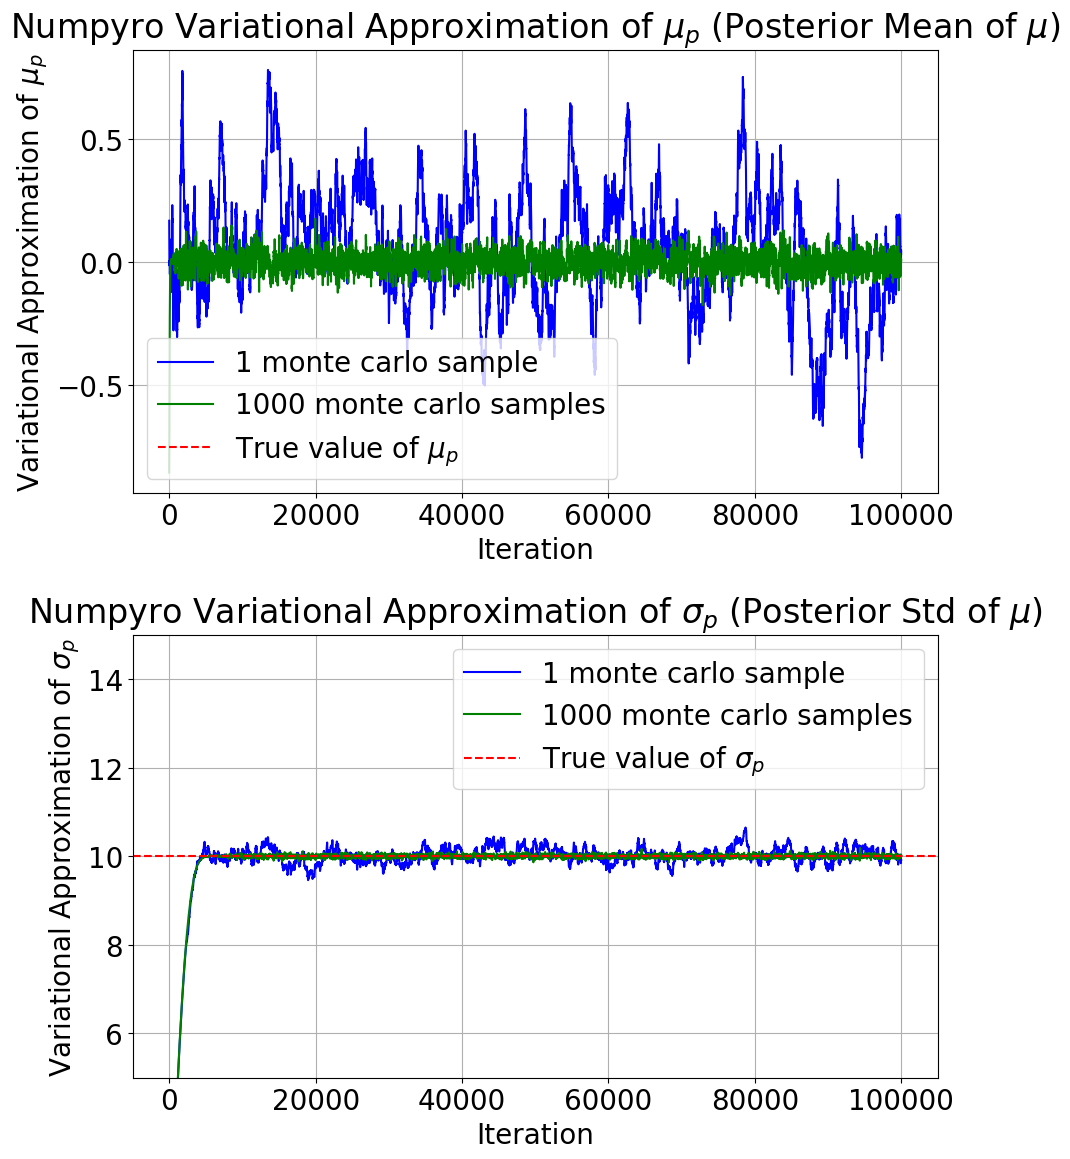

In [9]:
# plot single_tracker vs multi_tracker for the mean and std of mu
# add dashed lines for true values of mu mean and std which is N(0, 1)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# set font size to 14
plt.rcParams.update({'font.size': 20})

axs[0].plot(single_tracker['mu_loc'], label='1 monte carlo sample', color='blue')
axs[0].plot(multi_tracker['mu_loc'], label='1000 monte carlo samples', color='green')
# axs[0].plot(second_tracker['mu_loc'], label='1000 monte carlo samples, different optimizer', color='orange')
axs[0].axhline(true_mu_post, color='red', linestyle='--', label=r'True value of $\mu_p$')
axs[0].set_title(r'Numpyro Variational Approximation of $\mu_p$ (Posterior Mean of $\mu$)')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[0].legend()
axs[0].grid()

axs[1].plot(single_tracker['std_loc'], label='1 monte carlo sample', color='blue')
axs[1].plot(multi_tracker['std_loc'], label='1000 monte carlo samples', color='green')
axs[1].axhline(true_sigma_post, color='red', linestyle='--', label=r'True value of $\sigma_p$')
axs[1].set_title(r'Numpyro Variational Approximation of $\sigma_p$ (Posterior Std of $\mu$)')
axs[1].set_xlabel('Iteration', fontsize=20)
axs[1].set_ylabel(r'Variational Approximation of $\sigma_p$')
axs[1].legend()
axs[1].grid()
axs[1].set_ylim(true_sigma_post * .5, true_sigma_post * 1.5)

plt.tight_layout()
plt.show()